In [1]:
using Multitaper, Plots, DelimitedFiles, Statistics, StatsBase, LinearAlgebra, Distributions, LombScargle, FINUFFT,
      LaTeXStrings, StatsFuns

mdmultispec_noadapt (generic function with 1 method)

# Analysis of <em>Kepler</em> Q3 observations of KIC 6102338 from  [Dodson-Robinson & Haley (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....167...22D/abstract) section 4

### Mathematical method by [Chave (2019)](https://academic.oup.com/gji/article/218/3/2165/5519233?login=false)

Here we use a missing-data multitaper power spectrum to identify oscillatory signals at two fundamental rotation frequencies $f_0$ and $f_1$, their first harmonics $2f_0$ and $2f_1$, and the second harmonic $3f_0$. By measuring harmonic/fundamental power ratios, we infer that the surface shear is antisolar (rotation is slower at the equator than at high latitudes).

For help understanding file-reading and plotting commands, check out [Julia quickstart for astronomers](https://github.com/lootie/Multitaper.jl/blob/master/Julia_quickstart/Julia_quickstart_astronomers.ipynb)

In [2]:
Kep = readdlm("KIC6102338_rotatingstar.txt", comments=true)
BJD = Kep[:,1]
flux = Kep[:,2]
time = BJD .- BJD[1]

4134-element Vector{Float64}:
  0.0
  0.02043283497914672
  0.04086556937545538
  0.06129850400611758
  0.08173133851960301
  0.10216407291591167
  0.12259690696373582
  0.14302984112873673
  0.16346257459372282
  0.18389540817588568
  0.2043283418752253
  0.2247610748745501
  0.24519390799105167
  ⋮
 89.00522562302649
 89.02565881377086
 89.04609180474654
 89.0665248958394
 89.0869578877464
 89.10739107942209
 89.12782417144626
 89.1482572639361
 89.1686903568916
 89.2095565428026
 89.22998963622376
 89.25042273011059

### Remove $3\sigma$ outliers, which are likely caused by flares

In [3]:
not_outliers = findall(abs.(flux .- mean(flux)) .< 3*std(flux))
BJD = BJD[not_outliers]
flux = flux[not_outliers]
time = time[not_outliers]

4131-element Vector{Float64}:
  0.0
  0.02043283497914672
  0.04086556937545538
  0.06129850400611758
  0.08173133851960301
  0.10216407291591167
  0.12259690696373582
  0.14302984112873673
  0.16346257459372282
  0.18389540817588568
  0.2043283418752253
  0.2247610748745501
  0.24519390799105167
  ⋮
 89.00522562302649
 89.02565881377086
 89.04609180474654
 89.0665248958394
 89.0869578877464
 89.10739107942209
 89.12782417144626
 89.1482572639361
 89.1686903568916
 89.2095565428026
 89.22998963622376
 89.25042273011059

### Median, mean, minimum, and maximum of timestep distribution

In [4]:
dt = diff(time)
println(median(dt))
println(mean(dt))
println(maximum(dt))
println(minimum(dt))

0.02043277770280838
0.021610271847484402
2.1045807101763785
0.020432303193956614


### Rayleigh resolution

2 x Rayleigh resolution is the minimum frequency separation required to distinguish between two oscillations

In [5]:
Ray = 1 / time[end]
println(Ray, " ", 2*Ray)

0.011204428723256098 0.022408857446512196


### Create a vector of scaled timestamps that have integer values and $\Delta t = 1$

Solving the eigenvalue problem that calculates the Chave tapers requires this type of grid.

In [6]:
tscale = round.(time ./ median(dt))

4131-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
   10.0
   11.0
   12.0
    ⋮
 4356.0
 4357.0
 4358.0
 4359.0
 4360.0
 4361.0
 4362.0
 4363.0
 4364.0
 4366.0
 4367.0
 4368.0

### Make a histogram of the deviations of the scaled timesteps from unity

Verify that the deviations are small so we can assume uniform time sampling

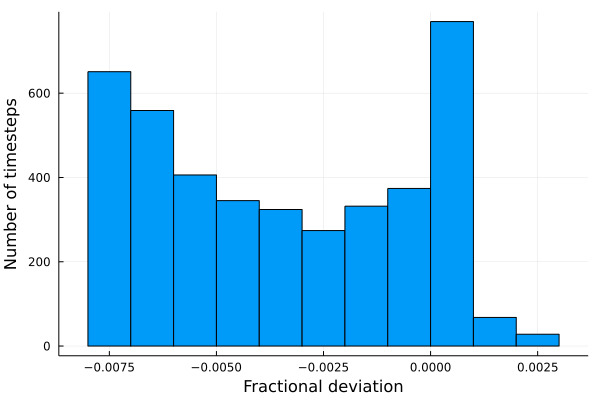

In [7]:
tscale_check = histogram((time ./ median(dt)) .- tscale, label=false, 
                          xlabel="Fractional deviation", ylabel="Number of timesteps")

### Periods of differential rotation identified by [Reinhold et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...560A...4R/abstract)

To visually separate the two fundamental rotation signals in a plot of the multitaper power spectrum estimate, we want them to be separated by at least the bandwidth. Note that this is not necessary for the F-test, which has the Rayleigh resolution.

In [8]:
p1 = 5.2665
p2 = 4.0734
f1 = 1/p1
f2 = 1/p2
println("Frequency separation: ", f2-f1)
println("Maximum NW: ", (f2-f1)/Ray)

Frequency separation: 0.055615737181142405
Maximum NW: 4.963728053863688


### Calculate the missing-data Slepian sequences according to [Chave (2019)](https://academic.oup.com/gji/article/218/3/2165/5519233?login=false)

Syntax of the call to <tt>mdslepian()</tt> (short for missing-data Slepian sequences):
<ul>
    <li>The first argument is the SCALED bandwidth in units where the Nyquist frequency is 0.5, denoted $\varpi$ in <a href="https://ui.adsabs.harvard.edu/abs/2024AJ....167...22D/abstract">Dodson-Robinson & Haley (2024)</a>. See section 2.7 for tips on choosing the bandwidth. Here we set $\varpi$ according to resolution considerations.</li>
    <li>The second argument is the number of tapers $K$.</li>
    <li>The third argument is the vector of INTEGER time indices $t = t_0, t_1, t_2, \ldots, t_{N-1}$ with rescaled $\Delta t = 1$ except where there are gaps.</li>
<ul>

In [9]:
NW = 4.5
W = NW / length(time)
K = 7
lam, sleps = mdslepian(W, K, tscale)

([0.9925754444558118, 0.9892114413978508, 0.9890915000295012, 0.9809114196555466, 0.9666717029792068, 0.904084196133859, 0.8943643228662137], [0.0003146305157133607 2.407552012832423e-5 … 0.006122401225281134 0.006177062820478389; 0.00031577138464505654 2.4167021767818736e-5 … 0.006164664774498043 0.006215010440899464; … ; -7.4421496789184305e-6 0.0012129058106471191 … -0.0035393187916386067 -0.004812547010991673; -1.0330261865920676e-5 0.0011934640818674763 … -0.003520838435699676 -0.004788214671429772])

### Calculate the bound on the bias according to Equation 14 of [Dodson-Robinson & Haley (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....167...22D/abstract)

In [10]:
varflux = var(flux)
println("Bias: ", varflux * (1 - minimum(lam)))

Bias: 443.1638671849048


### Print the spectral concentrations of the missing-data Slepian sequences

In [11]:
println(lam)

[0.9925754444558118, 0.9892114413978508, 0.9890915000295012, 0.9809114196555466, 0.9666717029792068, 0.904084196133859, 0.8943643228662137]


### Identify the large gaps in the time series

In [12]:
gaps = findall(dt .> 3*median(dt))
println(gaps)

[348, 976, 1417, 2875]


### Plot the observed fluxes after outlier rejection

This is the top of Figure 10

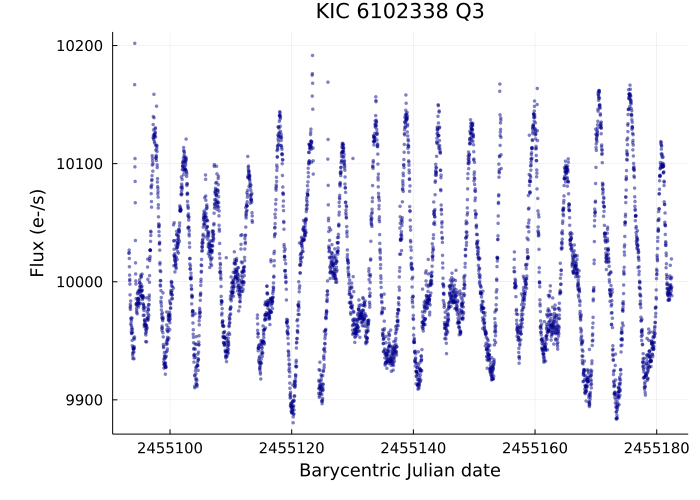

In [13]:
pflux_outlier_reject = scatter(BJD, flux, ylabel="Flux (e-/s)", legend=false, xtickfontsize=10, 
                               left_margin = 8Plots.mm, xguidefontsize=12, ytickfontsize=10, 
                               yguidefontsize=12, msw=0, title="KIC 6102338 Q3", ma=0.5, ms=2, 
                               wsize=(700,500), bottom_margin = 5Plots.mm, color=:darkblue,
                               xlabel="Barycentric Julian date")
# savefig("KIC6102338_flux.pdf")

### Plot the missing-data Slepian sequences (tapers)

In our call to <tt>plot()</tt>, we are making use of the fact that you can pass in an array of size <tt>(nrows, ncolumns) = (length(x), number_of_series)</tt> as the y-value argument and <tt>Plots.jl</tt> will automatically treat each column as a separate series to be plotted. Here we want each taper to be a series on the plot, so <tt>number_of_series</tt> = $K = 6$.

A weird quirk of <tt>Plots.jl</tt> is that the double-loop that adds the gap shading prevents the plot from displaying in this cell. It will show up as the bottom of a two-panel plot in the cell after this one, but if you want to display it here, add <br />
<tt>plot(psleps)</tt><br />
to the bottom of this cell.

In [14]:
ls = [:solid :dashdot :dash :dot :solid :dashdot :dash]
lw = [3 3 3 3 3 2]

psleps = plot(BJD, sleps, xlabel="Barycentric Julian date", ylabel=L"w_t^{(k)}",  
                 xtickfontsize=10, left_margin = 8Plots.mm, ls=ls, lw=lw,
                 xguidefontsize=12, ytickfontsize=10, yguidefontsize=12, legendfontsize=7,
                 titlefontsize=14, wsize=(900,500), bottom_margin = 5Plots.mm, 
                 labels=round.(lam, digits=4)', legend_position=(0.9, 1.25), 
                 title="MDSS: "*L"K = 7, N\varpi = 4.5")

for i in 1:length(gaps)
    for j in 1:K
        plot!([BJD[gaps[i]], BJD[gaps[i]+1]], [-0.055, -0.055], fillrange=[0.055, 0.055], lw=4, 
               color=:lightgray, label=false)
    end
end

### Combined plot of data and tapers

This is Figure 10

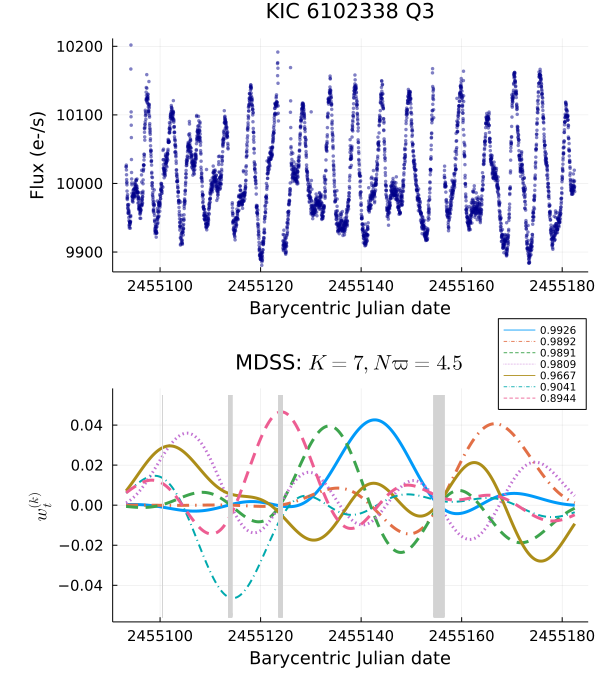

In [15]:
plot(pflux_outlier_reject, psleps, layout=(2,1), wsize=(600,700))
# savefig("KIC6102338_flux_tapers.pdf")

### Print out the gap lengths in scaled units ($\Delta t = 1$)

In [16]:
for i in 1:length(gaps)
  println(tscale[gaps[i]+1] - tscale[gaps[i]])
end

8.0
40.0
43.0
103.0


### Print out the bandwidth in scaled units

In [17]:
println(W)

0.0010893246187363835


### Print out the bandwidth in physical units

In [18]:
trueW = W / median(dt)
println(trueW)

0.053312605587964745


### Multitaper power spectrum estimate

Syntax of the call to <tt>mdmultispec_noadapt()</tt> (missing-data multitaper power spectrum estimate without adaptive weighting):<br />
<ul>
    <li>The first argument is the vector of INTEGER time indices $t = t_0, t_1, t_2, \ldots, t_{N-1}$. We have to pass in the time indices so the software will know where the gaps are.</li>
    <li>The second argument is the vector of observations. Although <tt>Multitaper.jl</tt> will subtract off the time series mean, I have deliberately ingrained the habit of zero-meaning my data anytime I'm doing Fourier analysis.</li>
    <li><tt>bw</tt> is the bandwidth in SCALED units where $\Delta t = 1$ and the Nyquist frequency is 0.5. The default is given by $N\varpi = 5, \varpi = N\varpi / N$.</li>
    <li><tt>k</tt> is the number of tapers. The default is <tt>floor</tt>$(2N\varpi)$.</li>
    <li><tt>nz</tt> tells the software what factor to use in padding the time-domain data / oversampling the frequency grid. The native (Rayleigh) resolution of a power spectrum estimate is $1 / (t_{N-1} - t_0)$, which gives an equal number of frequency gridpoints as observations if the time grid is evenly spaced. Your frequency grid will have length <tt>nz</tt>$\times N$. Equivalent to <tt>samples_per_peak</tt> in <tt>astropy.timeseries.LombScargle</tt>.</li>
        <li>If the physical time interval between observations is something other than 1, pass that in using the <tt>dt</tt> keyword.</li>
</ul>

Defaults are to perform the F-test (<tt>Ftest = true</tt>) and calculate jackknife confidence intervals (<tt>jk = true</tt>). You can turn off either of these calculations with <tt>Ftest = false</tt> and <tt>jk = false</tt>.</li>

The output of <tt>mdmultispec_noadapt()</tt> is a tuple. First in the tuple is a structure of type <tt>MTSpectrum</tt> defined in [<tt>StructsTypes.jl</tt>](https://github.com/lootie/Multitaper.jl/blob/master/src/StructsTypes.jl). In cells 21 and 22, we directly access the structure fields for frequency (<tt>.f</tt>) and p-value given by the F-test at each frequency (<tt>.Fpval</tt>). The spectrum is in field <tt>.S</tt>. Second in the tuple is the degrees of freedom $\nu$, which we will not need here.

See the [<tt>Examples</tt>](https://github.com/lootie/Multitaper.jl/blob/master/Examples/01_basic_multitaper.ipynb) directory for more power spectrum estimates.

In [19]:
mtspec, nu = mdmultispec_noadapt(tscale, flux .- mean(flux), bw=W, k=K, nz=2, dt=median(dt))

(MTSpectrum{EigenCoefficient, Vector{Float64}, Nothing}(0.0:0.003948126164065153:24.470485964875817, [104.29092839880366, 205.71279263248675, 188.6105917936745, 157.82883421812465, 148.6208512863933, 187.4498390770373, 234.62052071603662, 232.07156201541727, 213.89135312968776, 247.01292621807318  …  0.890932686191079, 0.8609305877734356, 0.875166164468275, 0.9525753584245306, 1.0222033114088283, 1.0328699307233922, 1.0120152332689163, 0.9941584142510106, 0.9839569557823467, 0.49008143228421025], nothing, MTParameters(4.5, 7, 4131, 1.0, 12396, 1, nothing), EigenCoefficient(ComplexF64[-31.228673393268682 - 1.754428366043891e-11im -59.07213232372415 - 1.5724194319434643e-10im … 76.19411064190777 - 1.80252099339086e-12im 55.47628403698611 + 3.5053277587858155e-11im; -22.35151281134648 + 20.990456033333583im 1.2504360270197454 + 56.45557472297195im … 66.18062943018364 - 38.99434223258456im 38.97470984306709 - 40.15925923101052im; … ; 2.6762682074709265 + 5.282472245327023im 1.5960958462879

### Plot the multitaper power spectrum estimate

<tt>Multitaper.jl</tt> has a plot recipe for structures of type <tt>MTSpectrum</tt>. It automatically overlays the confidence interval on the power spectrum estimate.

By default, the plot recipe puts the labels "Frequency" on the x-axis and "Spectrum" on the y-axis. Both are overridden here.

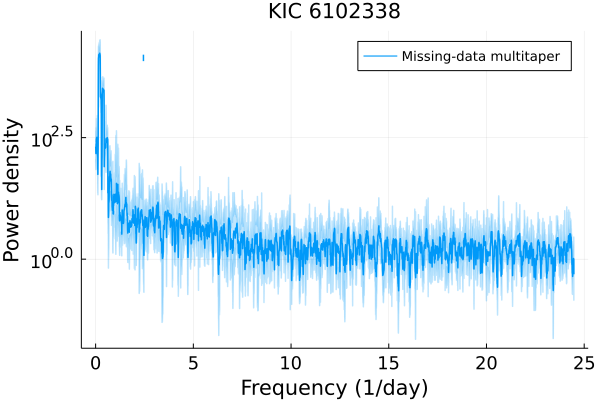

In [20]:
specplot = plot(mtspec, xlabel="Frequency (1/day)", ylabel="Power density", label="Missing-data multitaper", 
                title="KIC 6102338", lw=1.5, xtickfontsize=12, ytickfontsize=12, 
                xguidefontsize=14, yguidefontsize=14, legendfontsize=9)

### Find oscillations with F-test FAP < 0.001 (significance > 0.999)

In [21]:
sig = findall(mtspec.Fpval .< 0.001)

11-element Vector{Int64}:
   48
   49
   63
   98
   99
  126
  146
 2022
 2528
 2990
 6072

### Find oscillation with F-test FAP < 1/N (significance > 1-1/N)

In [22]:
threshold = 1/length(tscale)
sigN = findall(mtspec.Fpval .< threshold)

6-element Vector{Int64}:
   49
   63
   98
   99
  126
 2990

### Calculate the Lomb-Scargle periodogram

In [23]:
ls = lombscargle(time, flux, normalization=:psd, maximum_frequency=maximum(mtspec.f),
                 nyquist_factor=1, samples_per_peak=2)
fls, pls = freqpower(ls)

(0.0028011071808140245:0.005602214361628049:24.467671224410505, [2270.636021514873, 3184.0588575372335, 2127.932972205686, 3719.0225647427, 7650.689754494394, 661.8856013210085, 16812.036136060615, 30789.814883031933, 22624.02074992325, 10149.598391161137  …  52.30804330961806, 144.38145705707296, 83.46602105078449, 270.6252096504066, 110.04513116825736, 2639.3728134670855, 3306.7133311316034, 1008.037603108732, 359.85835401428534, 644.1388233890431])

### Quick function to get the upper and lower bounds of the 95% confidence interval at any point in the frequency grid

Here we access the <tt>.jkvar</tt> field of the <tt>MTSpectrum</tt> structure

In [24]:
function getCI(spec, ind)
    z = norminvcdf(0,1,0.975)
    return (spec.S[ind] * exp(z*sqrt(spec.jkvar[ind])),  spec.S[ind] * exp(-z*sqrt(spec.jkvar[ind])))
end

getCI (generic function with 1 method)

### For the oscillations detected at the 1-1/N significance level, print out the frequency and the confidence interval on the power

In [25]:
for i in 1:length(sigN)
    println(mtspec.f[sigN[i]], " ", getCI(mtspec, sigN[i]))
end

0.18951005587512734 (28786.878481283704, 8388.423267403614)
0.24478382217203948 (3593.2030537895844, 1348.295500156883)
0.38296823791431983 (5266.359498561357, 1725.21769755846)
0.386916364078385 (5127.547118830476, 1902.7333404468131)
0.4935157705081441 (365.29683369490095, 110.09281552014909)
11.80094910439074 (5.459283520229755, 1.2384851146302396)


### To be very sure about the antisolar shear, calculate harmonic/fundamental power ratios using the bounds of the confidence intervals

In [26]:
println(getCI(mtspec, sigN[3]) ./ getCI(mtspec, sigN[1]))
println(getCI(mtspec, sigN[5]) ./ getCI(mtspec, sigN[2]))
println(getCI(mtspec, sigN[3]) ./ getCI(mtspec, sigN[1])[end:-1:1])
println(getCI(mtspec, sigN[5]) ./ getCI(mtspec, sigN[2])[end:-1:1])

(0.18294305518347095, 0.20566650520157284)
(0.1016632871080412, 0.08165332859698714)
(0.6278127999365251, 0.05993069719873034)
(0.27093232429567277, 0.030639185671413507)


### Plot the multitaper power spectrum estimate with annotations for rotation frequencies and their harmonics

<tt>Multitaper.jl</tt> has a plot recipe for structures of type <tt>MTSpectrum</tt>. It automatically overlays the confidence interval on the power spectrum estimate.

This is the top panel of Figure 11. The annotation spacing looks weird in this plot, but it looks right once the three panels are combined.

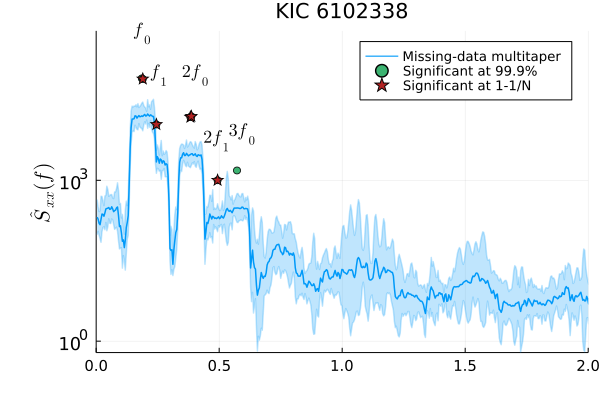

In [27]:
meddt = median(dt)
ylim = (30*meddt, 3e7*meddt)

specplot2 = plot(mtspec, ylabel=L"\hat{S}_{xx}(f)", label="Missing-data multitaper", 
                title="KIC 6102338", lw=1.5, xtickfontsize=10, ytickfontsize=12, ylim=ylim,
                xguidefontsize=12, yguidefontsize=14, legendfontsize=9, xlim=(0,2), 
                left_margin=8Plots.mm, xlabel=" ")

scatter!(mtspec.f[sig], 5 .* mtspec.S[sig], label="Significant at 99.9%", markersize=4,
         color=:mediumseagreen)
scatter!(mtspec.f[sigN], 5 .* mtspec.S[sigN], label="Significant at 1-1/N", 
         marker=:star5, markersize=6, color=:firebrick)

annotate!([(f1, 3e7*meddt, text(L"f_0",12))])
annotate!([(2*f1 + 0.5*trueW, 5e6*meddt, text(L"2 f_0",12))])
annotate!([(3*f1 + 0.5*trueW, 4e5*meddt, text(L"3 f_0",12))])
annotate!([(f2 + 0.2*trueW, 5e6*meddt, text(L"f_1",12))])
annotate!([(2*f2, 3e5*meddt, text(L"2 f_1",12))])

# savefig("KIC6102338_Q3_powspec.pdf")

### Plot the F-test p-value and mark significant oscillations

This is the middle of Figure 11

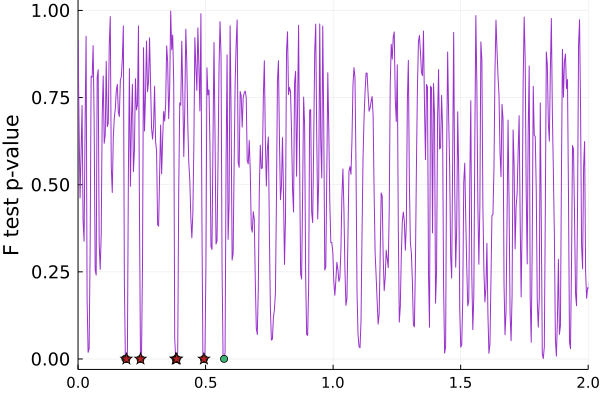

In [28]:
Fplot = plot(mtspec.f, mtspec.Fpval, ylabel="F test p-value", xtickfontsize=10, 
             ytickfontsize=12, yguidefontsize=14, label=false, color=:darkorchid,
             top_margin=-4Plots.mm, xlim=(0,2))

scatter!(mtspec.f[sig], mtspec.Fpval[sig], color=:mediumseagreen, label=false)
scatter!(mtspec.f[sigN], mtspec.Fpval[sigN], color=:firebrick, marker=:star5, 
         markersize=6, label=false)

I wanted to plot the 1/N false alarm threshold of the Lomb-Scargle periodogram, but <tt>LombScargle.jl</tt> won't give bootstrap false alarm thresholds for the power spectral density normalization. I calculated the requisite false alarm threshold with <tt>astropy.timeseries.LombScargle</tt>.

In [29]:
LS_fal_threshold = 71470.272 # Calculated with astropy

71470.272

### Plot Lomb-Scargle periodogram on the multitaper confidence intervals 

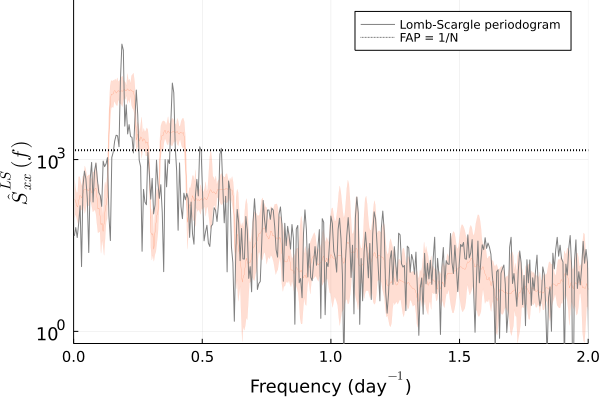

In [30]:
perplot = plot(mtspec, xlabel="Frequency (day"*L"^{-1}"*")", ylabel=L"\hat{S}^{LS}_{xx}(f)", 
               lw=0.2, xtickfontsize=10, ytickfontsize=12, xguidefontsize=12, 
               yguidefontsize=14, legendfontsize=8, bottom_margin=3Plots.mm,
               color=:coral, label=false, ylim=ylim, top_margin=-4Plots.mm,
               xlim=(0,2))

plot!(fls, meddt .* pls, color=:gray, label="Lomb-Scargle periodogram", yscale=:log10)
hline!([LS_fal_threshold * meddt], color=:black, ls=:dot, lw=2, label="FAP = 1/N")

### Combined multitaper power spectrum, F-test p-value, and Lomb-Scargle plot

Figure 11 of  [Dodson-Robinson & Haley (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....167...22D/abstract)

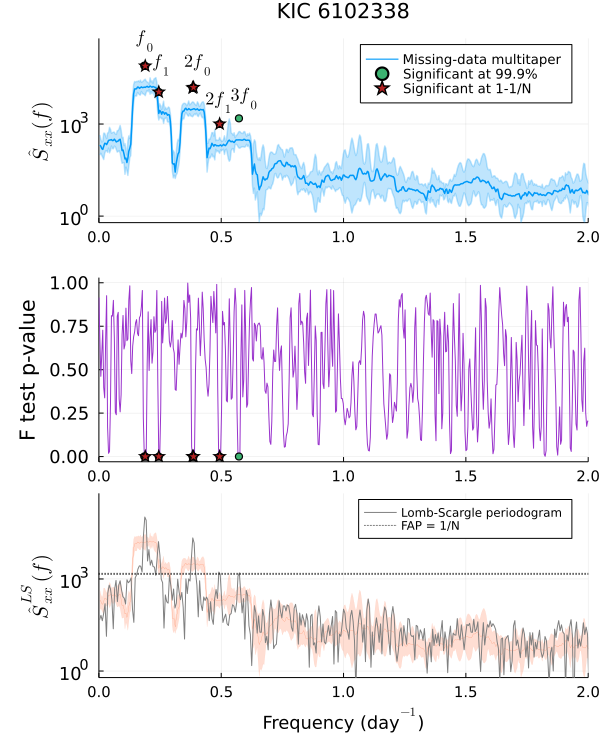

In [31]:
plot(specplot2, Fplot, perplot, layout=(3,1), wsize=(600,750))
# savefig("KIC6102338_Q3_spec.png")